# 📊 **Perbandingan Kinerja Fine-Tuned IndoBERT vs IndoBERT Embedding + SVM**
Notebook ini membandingkan performa dua pendekatan dalam klasifikasi sentimen terhadap tagar #KaburAjaDulu:
1. Fine-Tuned IndoBERT
2. IndoBERT Embedding + SVM (dengan class weight seimbang)

Data yang digunakan adalah dataset `test_set_final.csv` yang berisi tweet terlabel hasil pseudo-labeling IndoBERT dan sudah dibersihkan.


## 📚 **Import Library**

In [1]:
# === 1. Import Library ===
import numpy as np
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer
from datasets import Dataset

## 💾 **Load Dataset dan Persiapan Teks**
Pada bagian ini, kita memuat dataset `test_set_final.csv` dan menyiapkan kolom `clean_text` dan `label_num` sebagai input dan label untuk evaluasi model.


In [2]:
# === 2. Load Dataset ===
test_df = pd.read_csv("../../data/split_data_half/test_dataset.csv")
test_texts = test_df["normalized"].tolist()
test_labels = test_df["label_num"].to_numpy()

# Load embeddings hasil IndoBERT (untuk SVM)
X_test_svm = np.load("../../data/split_data_half/embeddings/X_test_half.npy")  # sesuaikan nama file jika beda


## 🔤 **Evaluasi IndoBERT Embedding + SVM (class_weight='balanced')**
Pada bagian ini, kita menggunakan model SVM yang dilatih dengan representasi embedding dari SentenceTransformer (IndoBERT) dan class_weight disetel ke "balanced" agar menangani ketidakseimbangan kelas.


In [3]:
# === 3. Load Model IndoBERT Embedding + SVM ===
svm_model = load("../../models/svm_model_half.joblib")
svm_preds = svm_model.predict(X_test_svm)

## 🤖 **Evaluasi Fine-Tuned IndoBERT**
Model yang telah dilatih menggunakan data pseudo-label sebanyak 3000 tweet akan dievaluasi menggunakan dataset test ini.


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "../../models/indoBERT_finetuning_half"

# Load tokenizer dan model dengan Auto*
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


# Tokenisasi test set
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt", max_length=256)

# Konversi ke Dataset HuggingFace
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": torch.tensor(test_labels, dtype=torch.long)
})

# Evaluasi pakai Trainer
trainer = Trainer(model=model)
outputs = trainer.predict(test_dataset)

preds_ft = torch.argmax(torch.tensor(outputs.predictions), axis=1).numpy()


## 📈 **Perbandingan Akurasi dan F1-Score**
Hasil evaluasi dari kedua model dibandingkan dengan visualisasi untuk melihat performa secara keseluruhan.


In [5]:
# === 5. Evaluasi dan Tampilkan Laporan ===
from sklearn.metrics import precision_recall_fscore_support

target_names = ['positif', 'netral', 'negatif']

print("🔹 IndoBERT + SVM")
print("Accuracy:", accuracy_score(test_labels, svm_preds))
print(classification_report(test_labels, svm_preds, target_names=target_names))

print("\n🔹 Fine-tuned IndoBERT")
print("Accuracy:", accuracy_score(test_labels, preds_ft))
print(classification_report(test_labels, preds_ft, target_names=target_names))

🔹 IndoBERT + SVM
Accuracy: 0.7982456140350878
              precision    recall  f1-score   support

     positif       0.48      0.55      0.51       315
      netral       0.68      0.74      0.71       851
     negatif       0.90      0.85      0.87      2368

    accuracy                           0.80      3534
   macro avg       0.69      0.71      0.70      3534
weighted avg       0.81      0.80      0.80      3534


🔹 Fine-tuned IndoBERT
Accuracy: 0.855970571590266
              precision    recall  f1-score   support

     positif       0.70      0.61      0.66       315
      netral       0.75      0.81      0.78       851
     negatif       0.92      0.91      0.91      2368

    accuracy                           0.86      3534
   macro avg       0.79      0.78      0.78      3534
weighted avg       0.86      0.86      0.86      3534



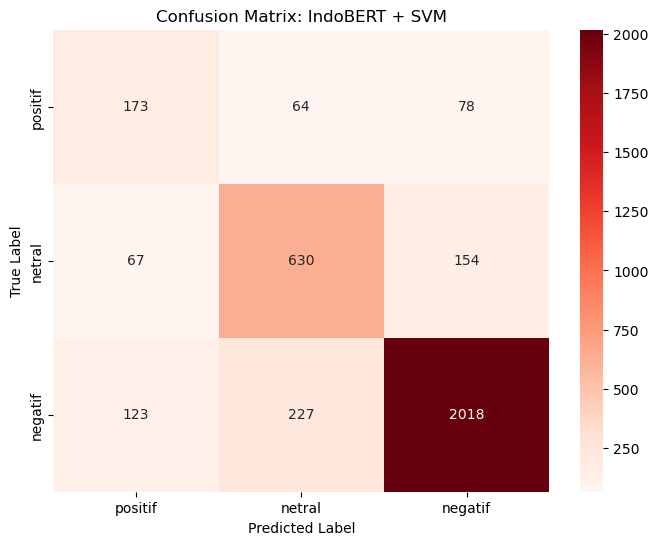

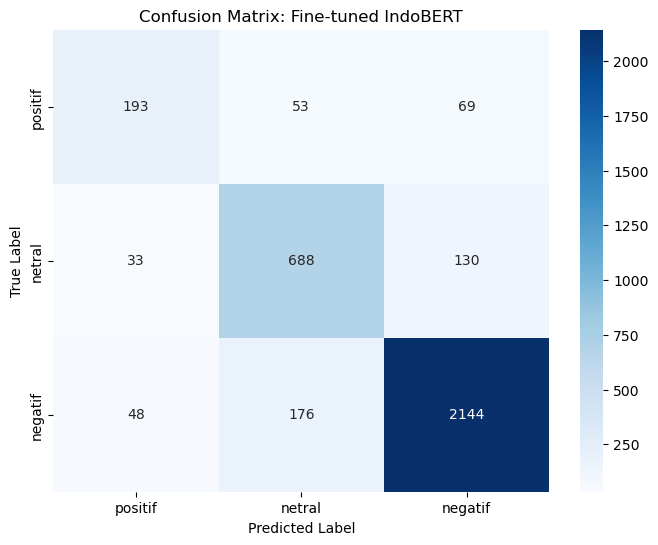

In [6]:
from sklearn.metrics import confusion_matrix

# Confusion matrix IndoBERT + SVM
cm_svm = confusion_matrix(test_labels, svm_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix: IndoBERT + SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Confusion matrix Fine-tuned IndoBERT
cm_ft = confusion_matrix(test_labels, preds_ft)
plt.figure(figsize=(8,6))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix: Fine-tuned IndoBERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [12]:
# Buat DataFrame dari list of dicts, bukan dict of lists
metrics_eval_df = pd.DataFrame([
    {"Metric": "Accuracy", "IndoBERT + SVM": metrics_svm[0], "Fine-tuned IndoBERT": metrics_ft[0]},
    {"Metric": "Precision", "IndoBERT + SVM": metrics_svm[1], "Fine-tuned IndoBERT": metrics_ft[1]},
    {"Metric": "Recall", "IndoBERT + SVM": metrics_svm[2], "Fine-tuned IndoBERT": metrics_ft[2]},
    {"Metric": "F1-Score", "IndoBERT + SVM": metrics_svm[3], "Fine-tuned IndoBERT": metrics_ft[3]},
])

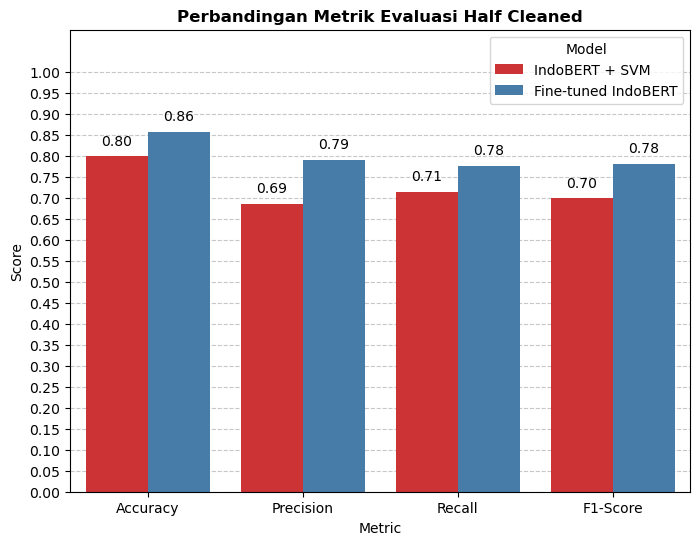

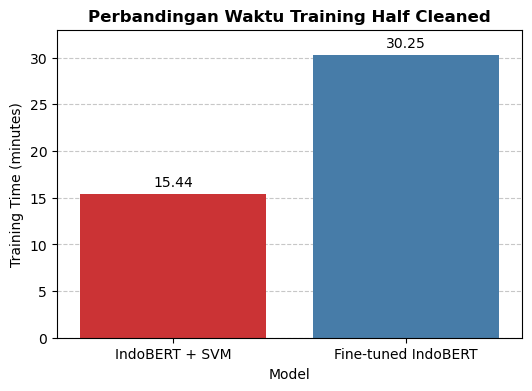

In [28]:
# === 6A. Buat Barplot Perbandingan Evaluasi Model ===

# Fungsi ambil metrik evaluasi
def get_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    return round(accuracy, 4), round(precision, 4), round(recall, 4), round(f1, 4)

# Hitung metrik
metrics_svm = get_metrics(test_labels, svm_preds)
metrics_ft = get_metrics(test_labels, preds_ft)

# DataFrame untuk metrik evaluasi
metrics_eval_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "IndoBERT + SVM": metrics_svm,
    "Fine-tuned IndoBERT": metrics_ft
})

# Melt untuk plotting
metrics_eval_melted = metrics_eval_df.melt(id_vars="Metric", var_name="Model", value_name="Score")

# Plot evaluasi model
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="Metric", y="Score", hue="Model", data=metrics_eval_melted, palette="Set1", zorder=2)

# Tambahkan angka di atas bar, dibulatkan ke 2 desimal
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Pastikan hanya menampilkan angka untuk bar yang ada
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Posisi x (tengah bar)
            height + 0.02,                   # Posisi y (sedikit di atas bar)
            f'{height:.2f}',                 # Nilai dibulatkan ke 2 desimal
            ha='center', va='bottom',        # Posisi teks: tengah secara horizontal, bawah secara vertikal
            fontsize=10
        )

plt.title("Perbandingan Metrik Evaluasi Half Cleaned", weight='bold')
plt.ylim(0, 1.1)  # Tambah sedikit ruang di atas untuk teks
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylabel("Score")
plt.legend(title="Model")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# === 6B. Buat Barplot Perbandingan Waktu Training ===

# Waktu training (dalam menit, sesuaikan kalau perlu)
training_times_minutes = {
    "IndoBERT + SVM": 15.44,
    "Fine-tuned IndoBERT": 30.25
}

# DataFrame untuk waktu training
training_time_df = pd.DataFrame({
    "Model": list(training_times_minutes.keys()),
    "Training Time (minutes)": list(training_times_minutes.values())
})

# Plot waktu training
plt.figure(figsize=(6, 4))
ax = sns.barplot(x="Model", y="Training Time (minutes)", hue="Model", data=training_time_df, palette="Set1", legend=False, zorder=2)

# Tambahkan angka di atas bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Pastikan hanya menampilkan angka untuk bar yang ada
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Posisi x (tengah bar)
            height + 0.5,                    # Posisi y (sedikit di atas bar)
            f'{height:.2f}',                 # Nilai yang ditampilkan, format 2 desimal
            ha='center', va='bottom',        # Posisi teks: tengah secara horizontal, bawah secara vertikal
            fontsize=10
        )

plt.title("Perbandingan Waktu Training Half Cleaned", weight='bold')
plt.ylabel("Training Time (minutes)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 33)  # Atur ketinggian sumbu y hingga sedikit di atas nilai maksimum (30.25)
plt.show()

## 📝 **Kesimpulan**
Fine-Tuned IndoBERT menunjukkan performa lebih tinggi dalam hal akurasi dan f1-score, terutama pada kelas mayoritas (positif), dibandingkan pendekatan IndoBERT Embedding + SVM. Hal ini menunjukkan bahwa fine-tuning model transformer secara langsung memberikan hasil yang lebih baik pada domain spesifik seperti tagar #KaburAjaDulu.
